In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx  
from scipy.spatial.distance import pdist, squareform  
from tqdm import tqdm  
from pyproj import Transformer, CRS  
# import seaborn as sns
# import regex as re

# from sklearn.neighbors import KernelDensity
# pd.options.display.max_columns = None
# from sklearn import preprocessing

In [2]:

from sklearn.model_selection import train_test_split #, cross_validate 
# from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression #, Ridge  , LogisticRegression , QuantileRegressor
from sklearn.ensemble import GradientBoostingRegressor # , RandomForestRegressor , HistGradientBoostingRegressor 
from sklearn.metrics import mean_absolute_percentage_error , r2_score, mean_squared_error
# from xgboost import XGBRegressor
# from geopy.geocoders import Nominatim
# from concurrent.futures import ThreadPoolExecutor

###########################################################################################################################
from gensim.models import Word2Vec
# from gensim.scripts.glove2word2vec import glove2word2vec
# from gensim.models import KeyedVectors
# import re
# from sklearn.decomposition import PCA
# from matplotlib import pyplot as plt
# from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import json
import plotly.express as px
import networkx as nx
from geopy.distance import geodesic
from scipy.spatial import cKDTree

# Load the real estate dataset for Mashhad, Iran

In [3]:
data= pd.read_excel('Mashhad_Real_Estate_Data.xlsx')
data.head()

,type,area_sq_m,latitude,longitude,age_years,floor_number,number_of_bedrooms,price,region,elevator,...,stone_façade,garden,direction,furnished,renovated,closet,em_mos,repainted,property_document_type,utilities_included
0,0,73.0,36.373776,59.475820,11,1,2,2200000000,12,1,...,0,0,0,0,0,0,0,0,1,4
1,0,100.0,36.327670,59.548380,7,1,2,4800000000,2,1,...,0,0,0,0,0,0,0,0,0,3
2,0,140.0,36.310605,59.504477,0,2,2,10200000000,9,1,...,0,1,1,0,0,0,0,0,1,4
3,0,65.0,36.400540,59.388382,6,4,1,870000000,12,0,...,0,0,0,0,0,1,1,1,2,0
4,0,200.0,36.373776,59.475820,0,0,3,5350000000,12,1,...,0,0,1,0,0,0,0,0,1,4


In [4]:
data.columns

Index(['type', 'area_sq_m', 'latitude', 'longitude', 'age_years',
       'floor_number', 'number_of_bedrooms', 'price', 'region', 'elevator',
       'parking', 'storage', 'shop', 'balcony', 'full_amenities', 'parquet',
       'ceramic_flooring', 'stone_façade', 'garden', 'direction', 'furnished',
       'renovated', 'closet', 'em_mos', 'repainted', 'property_document_type',
       'utilities_included'],
      dtype='object')

In [5]:
data.shape

(44781, 27)

In [6]:
# Check if there are any NaN values in the DataFrame
has_nan = data.isnull().any().any()
print(has_nan)  # True if there are any NaN values

False


## Filter the data to focus on properties within a specific geographic region of Mashhad
### The latitude and longitude ranges likely correspond to the city's central or most relevant area

In [14]:
# filtered_data = data[(data['longitude'] >= 59.45) & (data['longitude'] <= 59.7) & 
#                  (data['latitude'] >= 36.2) & (data['latitude'] <= 36.4)]
filtered_data = data[(data['longitude'] >= 59.45) & (data['longitude'] <= 59.55) & 
                 (data['latitude'] >= 36.28) & (data['latitude'] <= 36.4)]

filtered_data.shape

(29452, 27)

Randomly sample 10,000 data points from the filtered dataset

This creates a smaller, manageable dataset for analysis while maintaining diversity and reducing potential bias from any inherent order in the original data

In [15]:
np.random.seed(42)
shuffle_indices = np.random.choice(np.arange(filtered_data.shape[0]), size=5000, replace=False,)
df = filtered_data.iloc[shuffle_indices].reset_index(drop=True)
df['id'] = df.index  # Add this line to create a unique identifier for each house  
len(df) #, df.head(2)

5000

Visualize the spatial distribution of the selected properties using a scatter plot

In [16]:
import plotly.express as px
px.scatter(df , x="longitude", y="latitude",  width=400, height=400)#.write_image("img/spatial_distribution.png")

Creates a NetworkX graph of houses in Mashhad

In [17]:
import networkx as nx  
import pandas as pd  
from sklearn.preprocessing import StandardScaler  
from scipy.spatial import cKDTree  
import numpy as np  
from tqdm import tqdm  

def create_graph_from_dataframe(df, distance_threshold):  
    """  
    Create a graph from a DataFrame of property features, with edges based on  
    geographic proximity and weighted by property attributes.  

    Parameters:  
    - df: pd.DataFrame containing property features.  
    - distance_threshold: float, the distance threshold in meters for creating edges.  

    Returns:  
    - G: networkx.Graph, the generated graph with nodes and weighted edges.  
    """  
    # Separate numerical and binary features  
    numeric_features = ['area_sq_m', 'age_years', 'floor_number', 'number_of_bedrooms']  
    binary_features = ['elevator', 'parking', 'storage', 'balcony', 'parquet',   
                      'ceramic_flooring', 'stone_façade', 'garden', 'renovated']  
    
    # Normalize numeric features  
    scaler = StandardScaler()  
    df[numeric_features] = scaler.fit_transform(df[numeric_features])  

    # Build spatial index with cKDTree  
    coordinates = df[['latitude', 'longitude']].to_numpy()  
    tree = cKDTree(coordinates)  

    # Initialize graph  
    G = nx.Graph()  

    # Add nodes with attributes using the new 'id' column  
    for i, row in df.iterrows():  
        G.add_node(row['id'], **row.to_dict())  # Use the 'id' as the node identifier  

    # Find pairs of nodes within the threshold distance  
    pairs = tree.query_pairs(distance_threshold / 111000)  # Approximate meter-to-degree conversion  

    # Define a function to compute edge weight  
    def calculate_weight(df, idx1, idx2):  
        # no edge if the types are different  
        if df.loc[idx1, 'type'] != df.loc[idx2, 'type']:  
            return 0  
        geo_distance = np.linalg.norm(coordinates[idx1] - coordinates[idx2])  
        num_distance = np.linalg.norm(df.loc[idx1, numeric_features] - df.loc[idx2, numeric_features])  
        binary_similarity = np.sum(df.loc[idx1, binary_features] == df.loc[idx2, binary_features])  
        
        # Weight calculation (adjust formula as needed)  
        weight = (1 / (1 + geo_distance)) * (1 + binary_similarity) / (1 + num_distance)  
        return weight  

    # Add edges with weights  
    for idx1, idx2 in tqdm(pairs):  
        weight = calculate_weight(df, idx1, idx2)  
        if weight != 0:  
            G.add_edge(df.at[idx1, 'id'], df.at[idx2, 'id'], weight=weight)  # Use ids for edges  

    return G  

In [18]:
G = create_graph_from_dataframe(df, distance_threshold=1000) 

100%|██████████| 1860097/1860097 [1:01:57<00:00, 500.42it/s]


In [19]:
def is_complete_graph(G):
    n = G.number_of_nodes()
    if n < 2:
        return True  # A graph with 0 or 1 node is considered complete
    max_edges = n * (n - 1) // 2
    print(G.number_of_edges(), max_edges)
    return G.number_of_edges() == max_edges

In [20]:
print("G is complete:", is_complete_graph(G)) 

1770196 12497500
G is complete: False


In [18]:
# len(G.edges()), G.nodes[0]

In [21]:
import pickle

with open('D:/git/mamintoosi/Deepwalk-HPP/var/graph-NW-dist-1000.pkl', 'wb') as f:
    pickle.dump(G, f)

In [ ]:
# import pickle
# with open('D:/git/mamintoosi/Deepwalk-HPP/var/graph-dist-1000.pkl', 'rb') as f:
#     G = pickle.load(f)

In [22]:
df.head(1)

,type,area_sq_m,latitude,longitude,age_years,floor_number,number_of_bedrooms,price,region,elevator,...,garden,direction,furnished,renovated,closet,em_mos,repainted,property_document_type,utilities_included,id
0,0,-0.81362,36.322826,59.49541,0.650667,0.853148,-1.977046,2900000000,9,1,...,0,-1,0,0,0,0,0,1,4,0


In [23]:
import random  
import plotly.graph_objects as go  
import networkx as nx  
import pandas as pd  

# Assuming df is your dataframe with columns 'id', 'longitude', and 'latitude',  
# and G is the network graph created from the dataframe `df`.  

# Step 1: Select a random node from the graph  
random_node = random.choice(list(G.nodes))  

# Step 2: Get edges connected to the random node  
edges = G.edges(random_node)  

# Step 3: Collect all nodes to plot: random node plus its neighbors  
nodes_to_plot = [random_node] + list(G.neighbors(random_node))  

# Step 4: Filter the dataframe to get coordinates for selected nodes  
selected_houses = df[df['id'].isin(nodes_to_plot)]  

# Step 5: Create a Geo Scatter Plot for visible nodes  
fig = go.Figure()  

# Step 6: Plot edges  
for u, v in edges:  
    if u in selected_houses['id'].values and v in selected_houses['id'].values:  
        u_coords = selected_houses[selected_houses['id'] == u][['longitude', 'latitude']].values[0]  
        v_coords = selected_houses[selected_houses['id'] == v][['longitude', 'latitude']].values[0]  

        # Draw edges on the plot  
        fig.add_trace(go.Scattergeo(  
            lon=[u_coords[0], v_coords[0]],  
            lat=[u_coords[1], v_coords[1]],  
            mode='lines',  
            line=dict(width=1, color='blue'),  
            showlegend=False  
        ))  

# Step 7: Highlight the random node in red  
random_node_coords = selected_houses[selected_houses['id'] == random_node]  
fig.add_trace(go.Scattergeo(  
    lon=random_node_coords['longitude'],  
    lat=random_node_coords['latitude'],  
    mode='markers',  
    marker=dict(size=10, color='red', symbol='circle'),  # Random node in red  
    name='Random Node'  
))  

# Step 8: Adding selected (neighbors) houses to the plot  
fig.add_trace(go.Scattergeo(  
    lon=selected_houses['longitude'],  
    lat=selected_houses['latitude'],  
    mode='markers',  
    marker=dict(size=6, color='green', symbol='square'),  # Selected neighbors in green  
    name='Selected Neighbors'  
))  

# Step 9: Adding a subset of other houses to the plot (not selected)  
all_houses = df[df['id'].isin(list(G.nodes))]  
other_houses = all_houses[~all_houses['id'].isin(nodes_to_plot)]  # Exclude selected nodes  

# Randomly select a subset of other houses (e.g., 100)  
subset_size = min(1000, len(other_houses))  # Ensure we don't exceed the available number  
other_houses_sampled = other_houses.sample(n=subset_size, random_state=1)  # Sample random houses  

fig.add_trace(go.Scattergeo(  
    lon=other_houses_sampled['longitude'],  
    lat=other_houses_sampled['latitude'],  
    mode='markers',  
    marker=dict(size=5, color='blue', symbol='circle'),  # Other houses in blue  
    name='Other Houses'  
))  

# Step 10: Update layout to focus on Mashhad  
fig.update_layout(  
    title='Houses with Edges from a Random Node in Mashhad',  
    geo=dict(  
        scope='asia',  # Set the scope to Asia for better overview  
        projection_type='mercator',  
        showland=True,  
        landcolor='lightgray',  
        countrycolor='white',  
        fitbounds="locations",  # Automatically fits the map to all locations  
        center=dict(lon=random_node_coords['longitude'].values[0], lat=random_node_coords['latitude'].values[0])  # Center on random node  
    )  
)  

# Step 11: Show the final plot  
fig.show()

In [ ]:
import networkx as nx  
import pandas as pd  
import matplotlib.pyplot as plt  

# Assuming G is your NetworkX graph created from the df DataFrame  
# and df contains the relevant house data with longitude and latitude  

# Step 1: Calculate basic statistics  
num_nodes = G.number_of_nodes()  
num_edges = G.number_of_edges()  
degrees = [len(list(G.neighbors(node))) for node in G.nodes]  # List of number of neighbors for each node  

# Step 2: Compute minimum, maximum, and average number of neighbors  
min_neighbors = min(degrees)  
max_neighbors = max(degrees)  
avg_neighbors = sum(degrees) / num_nodes if num_nodes > 0 else 0  

# Step 3: Create a DataFrame for a better overview  
degree_distribution = pd.DataFrame({  
    'Node ID': list(G.nodes),  
    'Num Neighbors': degrees  
})  

# Step 4: Summary statistics of the degree distribution  
degree_stats = degree_distribution['Num Neighbors'].describe()  

# Step 5: Output the results  
print(f"Total number of nodes: {num_nodes}")  
print(f"Total number of edges: {num_edges}")  
print(f"Minimum number of neighbors: {min_neighbors}")  
print(f"Maximum number of neighbors: {max_neighbors}")  
print(f"Average number of neighbors: {avg_neighbors:.2f}")  
print("\nDegree Distribution Summary:")  
print(degree_stats)  

# # Optional: Visualize the degree distribution  
# plt.figure(figsize=(10, 6))  
# degree_distribution['Num Neighbors'].hist(bins=range(1, max_neighbors + 2), alpha=0.7, color='skyblue')  
# plt.title('Degree Distribution of Houses in Mashhad')  
# plt.xlabel('Number of Neighbors')  
# plt.ylabel('Frequency')  
# plt.xticks(range(1, max_neighbors + 2))  
# plt.grid(axis='y')  

# # Step 6: Save the plot as PNG file  
# plt.savefig('results/degree_distribution_houses_mashhad.png')  # Save the figure  

# # Show the plot  
# plt.show()

Total number of nodes: 5000
Total number of edges: 1770196
Minimum number of neighbors: 0
Maximum number of neighbors: 1715
Average number of neighbors: 708.08

Degree Distribution Summary:
count    5000.000000
mean      708.078400
std       661.700937
min         0.000000
25%       174.000000
50%       389.000000
75%      1634.000000
max      1715.000000
Name: Num Neighbors, dtype: float64


In [25]:
import numpy as np  

def random_walk(start, length):  
    walk = [str(start)]  # Starting node  

    for i in range(length):  
        # Get the neighbors of the current node  
        neighbors = [node for node in G.neighbors(start)]  
        
        # Check if the node has neighbors  
        if len(neighbors) == 0:  
            next_node = start  # If no neighbors, stay in the same node  
        else:  
            next_node = np.random.choice(neighbors, 1)[0]  # Choose a neighbor at random  
        
        walk.append(str(next_node))  
        start = next_node  # Move to the next node  
    
    return walk

In [26]:
nx.is_connected(G)

False

In [27]:
%%time
from tqdm import tqdm  

def generate_random_walks(subgraph, num_walks=80, walk_length=10):  
    """  
    Generate random walks for each node in the given subgraph.  

    Parameters:  
    - subgraph: The graph from which to generate random walks.  
    - num_walks: The number of random walks to generate for each node.  
    - walk_length: The length of each random walk.  

    Returns:  
    - A list of random walks.  
    """  
    print(subgraph.number_of_nodes())
    walks = []  
    for node in tqdm(subgraph.nodes, desc="Nodes"):  
        for _ in range(num_walks):  
            walks.append(random_walk(node, walk_length))  
    return walks  

CPU times: total: 0 ns
Wall time: 0 ns


In [30]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error  
from sklearn.model_selection import train_test_split, KFold  
from sklearn.ensemble import GradientBoostingRegressor  
# from gensim.models.word2vec import Word2Vec  

def fit_and_evaluate(model, X_train, y_train, X_test, y_test, filename=None, verbose=True, tolerance=0.2):  
    # Fit the model  
    model.fit(X_train, y_train)  

    # Make predictions  
    y_pred = model.predict(X_test)  

    # Metrics  
    r2 = r2_score(y_test, y_pred)  
    mape = mean_absolute_percentage_error(y_test, y_pred)  
    mse = mean_squared_error(y_test, y_pred)  

    # Range accuracy  
    correct_count = np.sum(np.abs(y_test - y_pred) <= tolerance * y_test)  
    accuracy = correct_count / len(y_test)  

    # Scatterplot  
    if verbose:  
        plt.scatter(y_test, y_pred)  
        plt.xlabel('Actual Prices')  
        plt.ylabel('Predicted Prices')  
        plt.title('Actual vs Predicted Prices')  
        if filename:  # Save only if filename is provided  
            plt.savefig(filename, format='png')  
        plt.close()  

    if verbose:  
        print(f"R2 Score: {r2}, MAPE: {mape}, MSE: {mse}, Accuracy: {accuracy}")  

    return r2, mape, accuracy, mse  

def create_word2vec_model(walks, vector_size):  
    model = Word2Vec(walks,  
                     hs=1,   # Hierarchical softmax  
                     sg=1,   # Skip-gram  
                     vector_size=vector_size,  
                     window=5,  
                     workers=4,  
                     seed=1)  
    return model  


def get_embeddings(model, G):  
    return np.array([model.wv[str(i)] for i in G.nodes()])  
    
def node2vec_model(df, G, vector_size):
    walks = generate_random_walks(G)
    wv_model = create_word2vec_model(walks, vector_size=vector_size)#, p=.5, q=4)  
    embeddings = get_embeddings(wv_model, G)    
    # print(node2vec_embeddings.shape)
    embeddings_df = pd.DataFrame(embeddings, columns=[f'node2vec_embedding_{i}' for i in range(embeddings.shape[1])])  
    # df_with_embeddings = pd.concat([df_filtered.reset_index(drop=True), embeddings_df], axis=1)  
    df_with_embeddings = pd.concat([df, embeddings_df], axis=1)  

    # Prepare for Regression  
    X = df_with_embeddings.drop(['price', 'id'], axis=1)  
    y = df_with_embeddings['price']  
    return X, y

def grid_search_embedding_size(df, G, embedding_sizes, random_state=42):  
    best_score = -np.inf  
    best_params = None  
    best_X = None  # To store the best X  
    best_y = None  # To store the best y  

    for vector_size in embedding_sizes:  
        print(f"Evaluating embedding size: {vector_size}")   
        
        X, y = node2vec_model(df, G, vector_size)  
        # has_nan = X.isnull().any().any()  
        # print(has_nan)  
        # print(df_filtered.shape)  
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.05, random_state=random_state)  
        
        # Use cross-validation to evaluate the model  
        kf = KFold(n_splits=5, shuffle=True, random_state=random_state)  
        scores = []  

        for train_index, val_index in kf.split(X_train):  
            X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]  
            y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]  
            
            model = GradientBoostingRegressor(loss='huber', n_estimators=100, max_depth=10, random_state=random_state)  
            r2, _, _, _ = fit_and_evaluate(model, X_train_kf, y_train_kf, X_val_kf, y_val_kf, verbose=False)  
            scores.append(r2)  

        mean_r2 = np.mean(scores)  
        print(f"Mean R2 score for embedding size {vector_size}: {mean_r2}")  

        if mean_r2 > best_score:  
            best_score = mean_r2  
            best_params = vector_size  
            best_X = X  # Store the best X for this vector_size  
            best_y = y  # Store the best y for this vector_size  

    print(f"Best embedding size: {best_params} with R2: {best_score}")  
    return best_params, best_X, best_y  # Return best parameters, X, and y

In [31]:
%%time

# Perform grid search on the training set  
embedding_sizes = [2, 3, 5]#, 10]#, 20, 30]  # Example sizes to test   
best_embedding_size, X, y = grid_search_embedding_size(df, G, embedding_sizes)  
best_embedding_size

Evaluating embedding size: 2
5000


Nodes: 100%|██████████| 5000/5000 [14:26<00:00,  5.77it/s]


Mean R2 score for embedding size 2: 0.73870039705866
Evaluating embedding size: 3
5000


Nodes: 100%|██████████| 5000/5000 [13:57<00:00,  5.97it/s]


Mean R2 score for embedding size 3: 0.752223583438188
Evaluating embedding size: 5
5000


Nodes: 100%|██████████| 5000/5000 [13:04<00:00,  6.37it/s]


Mean R2 score for embedding size 5: 0.7508042643244016
Best embedding size: 3 with R2: 0.752223583438188
CPU times: total: 50min 51s
Wall time: 46min 44s


3

In [32]:
# X, y = node2vec_model(df, G, best_embedding_size)
# print(df_filtered.shape)  
X_train_w_embeddings, X_test_w_embeddings, y_train, y_test = train_test_split(X, y,\
                                                test_size=0.05, random_state=42)
X_train_wo_embeddings = X_train_w_embeddings.iloc[:, :-best_embedding_size]
X_test_wo_embeddings = X_test_w_embeddings.iloc[:, :-best_embedding_size]

In [33]:
import pickle
# List of variables to save  
data_to_save = {  
    'X_train_wo_embeddings': X_train_wo_embeddings,  
    'X_train_w_embeddings': X_train_w_embeddings,  
    'X_test_wo_embeddings': X_test_wo_embeddings,  
    'X_test_w_embeddings': X_test_w_embeddings,  
    'y_train': y_train,  
    'y_test': y_test,  
    'best_embedding_size': best_embedding_size,  
}  

# Save the variables to a pickle file  
with open('D:/git/mamintoosi/Deepwalk-HPP/var/data_deepwalk-NW-dist-1000.pkl', 'wb') as f:  
    pickle.dump(data_to_save, f)  

print("Variables have been saved to var folder")

Variables have been saved to var folder


In [ ]:
# import pickle
# # Load the variables from the pickle file  
# with open('D:/git/mamintoosi/Deepwalk-HPP/var/data_deepwalk-NW-dist-1000.pkl', 'rb') as f:  
#     loaded_data = pickle.load(f)  

# # Unpack the loaded data  
# X_train_wo_embeddings = loaded_data['X_train_wo_embeddings']  
# X_train_w_embeddings = loaded_data['X_train_w_embeddings']  
# X_test_wo_embeddings = loaded_data['X_test_wo_embeddings']  
# X_test_w_embeddings = loaded_data['X_test_w_embeddings']  
# y_train = loaded_data['y_train']  
# y_test = loaded_data['y_test']  
# best_embedding_size = loaded_data['best_embedding_size']  

# print("Variables have been loaded successfully!")

Variables have been loaded successfully!


## Without Word2Vec

In [34]:
model = GradientBoostingRegressor( loss = 'huber' , n_estimators=100 ,  max_depth=10 , random_state=5 )
r2, mape , accuracy,mse = fit_and_evaluate(model, X_train_wo_embeddings, \
                            y_train, X_test_wo_embeddings, y_test,'prediction_wo-deepwalk.png')

R2 Score: 0.7088666876849563, MAPE: 0.18982416597217902, MSE: 6.239403256848638e+18, Accuracy: 0.824


In [35]:
print(f"R2 Score: {r2:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"acc: {accuracy:.2f}")
final_score = (r2 + (1 - mape) + accuracy) / 3
print(f'Final score: {final_score:.2f}')

R2 Score: 0.71
MAPE: 0.19
RMSE: 2497879752.28
acc: 0.82
Final score: 0.78


In [36]:
# Fit the model on the entire training set  
model_final = GradientBoostingRegressor(loss='huber', n_estimators=100, max_depth=10, random_state=5)  
r2_with_deepwalk, mape_with_deepwalk, accuracy_with_deepwalk, mse_with_deepwalk = fit_and_evaluate(model_final,\
            X_train_w_embeddings, y_train, X_test_w_embeddings, y_test, 'prediction_w-deepwalk.png', verbose=True)

R2 Score: 0.7867415719736267, MAPE: 0.19701604501290626, MSE: 4.5704331112005765e+18, Accuracy: 0.8


In [37]:
print(f"R2 Score: {r2_with_deepwalk:.2f}")
print(f"MAPE: {mape_with_deepwalk:.2f}")
print(f"RMSE: {np.sqrt(mse_with_deepwalk):.2f}")
print(f"Accuracy: {accuracy_with_deepwalk:.2f}")
final_score_deepwalk = (r2_with_deepwalk + (1 - mape_with_deepwalk) + accuracy_with_deepwalk) / 3
print(f'Final score: {final_score_deepwalk:.2f}')

R2 Score: 0.79
MAPE: 0.20
RMSE: 2137857130.68
Accuracy: 0.80
Final score: 0.80


In [38]:
import numpy as np  
from scipy import stats  

# این مقادیر از مدل ها به دست آمده اند.  
n_samples = X_train_w_embeddings.shape[0]  #تعداد نمونه های داده ها  
mse_without_deepwalk = mse  # MSE مدل بدون DeepWalk  
# mse_with_deepwalk = 0.8195510061449558 # MSE مدل با DeepWalk  
num_features_without = X_train_wo_embeddings.shape[1] #تعداد ویژگی های مدل بدون DeepWalk  
num_features_with = X_train_w_embeddings.shape[1]    #تعداد ویژگی های مدل با DeepWalk  
num_added_params = num_features_with - num_features_without #تعداد پارامترهای اضافه شده (10)  


# محاسبه درجات آزادی (Degrees of Freedom)  
df_without = n_samples - num_features_without -1 # برای رگرسیون خطی  
df_with = n_samples - num_features_with -1      # برای رگرسیون خطی  

#محاسبه آماره F  
F = ((mse_without_deepwalk - mse_with_deepwalk) / num_added_params) / (mse_with_deepwalk / df_with)  

# محاسبه‌ی p-value  
p_value = 1 - stats.f.cdf(F, num_added_params, df_with)  

print(f"F-statistic: {F:.2f}")  
print(f"P-value: {p_value:.3f}")  

# تفسیر نتایج  
alpha = 0.05  
if p_value < alpha:  
    print("تفاوت بین دو مدل معنی‌دار است (p-value < 0.05).")  
else:  
    print("تفاوت بین دو مدل معنی‌دار نیست (p-value >= 0.05).")  

F-statistic: 574.53
P-value: 0.000
تفاوت بین دو مدل معنی‌دار است (p-value < 0.05).


In [40]:
import pandas as pd  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.svm import SVR  

# Gradient Boosting Regressor  
model_gb = GradientBoostingRegressor(loss='huber', n_estimators=100, max_depth=10, random_state=5)  
r2_gb, mape_gb, accuracy_gb, mse_gb = fit_and_evaluate(model_gb, X_train_wo_embeddings,\
        y_train, X_test_wo_embeddings, y_test, 'results/wo-deepwalk.png')  

r2_gb_deepwalk, mape_gb_deepwalk, accuracy_gb_deepwalk, mse_gb_deepwalk = fit_and_evaluate(model_gb,  
        X_train_w_embeddings, y_train, X_test_w_embeddings, y_test,  
        'results/deepwalk_pred_final.png', verbose=True)  

# # Support Vector Regressor (SVR)  
# model_svr = SVR(kernel='rbf')  
# r2_svr, mape_svr, accuracy_svr, mse_svr = fit_and_evaluate(model_svr,\
#         X_train_wo_embeddings, y_train,  \
#         X_test_wo_embeddings, y_test, 'results/wo-svr.png')  

# r2_svr_deepwalk, mape_svr_deepwalk, accuracy_svr_deepwalk, mse_svr_deepwalk = fit_and_evaluate(model_svr,  
#         X_train_w_embeddings, y_train, X_test_w_embeddings, y_test,  
#         'results/deepwalk_svr_pred_final.png', verbose=True)  

from sklearn.linear_model import LinearRegression  

# Linear Regression Model  
model_lr = LinearRegression()  

# Fit and evaluate the model without embeddings  
r2_lr, mape_lr, accuracy_lr, mse_lr = fit_and_evaluate(model_lr,  
        X_train_wo_embeddings, y_train,  
        X_test_wo_embeddings, y_test,   
        'results/wo-lr.png')  

# Fit and evaluate the model with embeddings  
r2_lr_deepwalk, mape_lr_deepwalk, accuracy_lr_deepwalk, mse_lr_deepwalk = fit_and_evaluate(model_lr,  
        X_train_w_embeddings, y_train,   
        X_test_w_embeddings, y_test,  
        'results/deepwalk_lr_pred_final.png', verbose=True)

# Random Forest Regressor  
model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=5)  
r2_rf, mape_rf, accuracy_rf, mse_rf = fit_and_evaluate(model_rf,\
        X_train_wo_embeddings, y_train,  \
        X_test_wo_embeddings, y_test, 'results/wo-rf.png')  

r2_rf_deepwalk, mape_rf_deepwalk, accuracy_rf_deepwalk, mse_rf_deepwalk = fit_and_evaluate(model_rf,  
        X_train_w_embeddings, y_train, X_test_w_embeddings, y_test,  
        'results/deepwalk_rf_pred_final.png', verbose=True)  

# Create a DataFrame to store results  
results_df = pd.DataFrame({  
    'Model': ['Gradient Boosting',   
              'Gradient Boosting (DeepWalk)',   
              'Linear Regression',   
              'Linear Regression (DeepWalk)',   
              'Random Forest',   
              'Random Forest (DeepWalk)'],  
    'R2 Score': [r2_gb,   
                 r2_gb_deepwalk,   
                 r2_lr,   
                 r2_lr_deepwalk,   
                 r2_rf,   
                 r2_rf_deepwalk],  
    'MAPE': [mape_gb,   
             mape_gb_deepwalk,   
             mape_lr,   
             mape_lr_deepwalk,   
             mape_rf,   
             mape_rf_deepwalk],  
    'Accuracy': [accuracy_gb,   
                 accuracy_gb_deepwalk,   
                 accuracy_lr,   
                 accuracy_lr_deepwalk,   
                 accuracy_rf,   
                 accuracy_rf_deepwalk],  
    'MSE': [mse_gb,   
            mse_gb_deepwalk,   
            mse_lr,   
            mse_lr_deepwalk,   
            mse_rf,   
            mse_rf_deepwalk]  
})

# Save the DataFrame to an Excel file  
results_df.to_excel('results/model_results_NW.xlsx', index=False)  

print("Results have been saved to model_results.xlsx")

R2 Score: 0.7088666876849563, MAPE: 0.18982416597217902, MSE: 6.239403256848638e+18, Accuracy: 0.824
R2 Score: 0.7867415719736267, MAPE: 0.19701604501290626, MSE: 4.5704331112005765e+18, Accuracy: 0.8
R2 Score: 0.6567783355705028, MAPE: 0.32411556905254324, MSE: 7.355731138541228e+18, Accuracy: 0.556
R2 Score: 0.658198564328009, MAPE: 0.32975455033239764, MSE: 7.325293605080729e+18, Accuracy: 0.576
R2 Score: 0.7219491776505864, MAPE: 0.1916428186264132, MSE: 5.959026786529395e+18, Accuracy: 0.8
R2 Score: 0.7706601151928707, MAPE: 0.19032981078663427, MSE: 4.915081729439566e+18, Accuracy: 0.796
Results have been saved to model_results.xlsx


In [9]:
import pandas as pd  

# Load the DataFrame from Excel file  
file_path = 'results/model_results_NW.xlsx'  
df = pd.read_excel(file_path)  

# Display the DataFrame to ensure it loaded correctly  
print(df)

                          Model  R2 Score      MAPE  Accuracy  \
0             Gradient Boosting  0.708867  0.189824     0.824   
1  Gradient Boosting (DeepWalk)  0.786742  0.197016     0.800   
2             Linear Regression  0.656778  0.324116     0.556   
3  Linear Regression (DeepWalk)  0.658199  0.329755     0.576   
4                 Random Forest  0.721949  0.191643     0.800   
5      Random Forest (DeepWalk)  0.770660  0.190330     0.796   

                   MSE  
0  6239403256848637952  
1  4570433111200577024  
2  7355731138541228032  
3  7325293605080728576  
4  5959026786529394688  
5  4915081729439565824  


In [10]:
# Create a new column to indicate if the model is DeepWalk or not  
df['Type'] = df['Model'].apply(lambda x: 'DeepWalk' if 'DeepWalk' in x else 'No DeepWalk')  

# Group the data by Type and Model to get the mean R2 Score and MSE  
summary_df = df.groupby(['Type', 'Model']).agg({'R2 Score': 'mean', 'MSE': 'mean'}).reset_index()

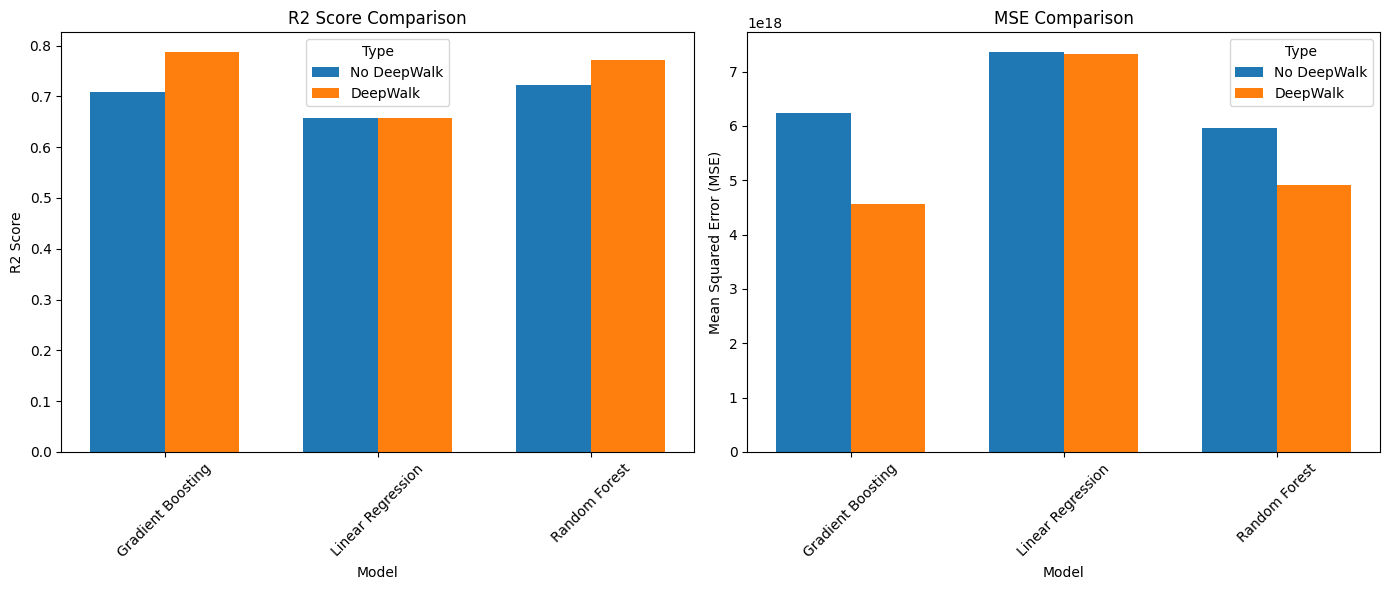

In [12]:
import pandas as pd  
import matplotlib.pyplot as plt  
import numpy as np  

# Load the DataFrame from the Excel file  
file_path = 'results/model_results_NW.xlsx'  
df = pd.read_excel(file_path)  

# Create a new column to indicate if the model is DeepWalk or not  
df['Type'] = df['Model'].apply(lambda x: 'DeepWalk' if 'DeepWalk' in x else 'No DeepWalk')  

# Group the data by Model to get the mean R2 Score and MSE  
summary_df = df.groupby(['Type', 'Model']).agg({'R2 Score': 'mean', 'MSE': 'mean'}).reset_index()  

# Prepare data for plotting  
no_deepwalk = summary_df[summary_df['Type'] == 'No DeepWalk']  
deepwalk = summary_df[summary_df['Type'] == 'DeepWalk']  

# Set the figure size for the plots  
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  

# Number of models  
num_models = len(no_deepwalk)  

# Set the bar width and x locations for the bars  
bar_width = 0.35  
x = np.arange(num_models)  

# Create bar plot for R2 Score comparison  
axs[0].bar(x - bar_width/2, no_deepwalk['R2 Score'], width=bar_width, label='No DeepWalk')  
axs[0].bar(x + bar_width/2, deepwalk['R2 Score'], width=bar_width, label='DeepWalk')  
axs[0].set_title('R2 Score Comparison')  
axs[0].set_xlabel('Model')  
axs[0].set_ylabel('R2 Score')  
axs[0].set_xticks(x)  
axs[0].set_xticklabels(no_deepwalk['Model'], rotation=45)  
axs[0].legend(title='Type')  

# Create bar plot for MSE comparison  
axs[1].bar(x - bar_width/2, no_deepwalk['MSE'], width=bar_width, label='No DeepWalk')  
axs[1].bar(x + bar_width/2, deepwalk['MSE'], width=bar_width, label='DeepWalk')  
axs[1].set_title('MSE Comparison')  
axs[1].set_xlabel('Model')  
axs[1].set_ylabel('Mean Squared Error (MSE)')  
axs[1].set_xticks(x)  
axs[1].set_xticklabels(no_deepwalk['Model'], rotation=45)  
axs[1].legend(title='Type')  

# Adjust layout to prevent overlap  
plt.tight_layout()  

# Save the plot as a PNG file  
plt.savefig('results/model_comparison_side_by_side.png')  

# Show the plot  
plt.show()

In [ ]:
import networkx as nx  
import pandas as pd  
import matplotlib.pyplot as plt  

# Assuming G is your NetworkX graph created from the df DataFrame  
# and df contains the relevant house data with longitude and latitude  

# Step 1: Calculate basic statistics  
num_nodes = G.number_of_nodes()  
num_edges = G.number_of_edges()  
degrees = [len(list(G.neighbors(node))) for node in G.nodes]  # List of number of neighbors for each node  

# Step 2: Compute minimum, maximum, and average number of neighbors  
min_neighbors = min(degrees)  
max_neighbors = max(degrees)  
avg_neighbors = sum(degrees) / num_nodes if num_nodes > 0 else 0  

# Step 3: Create a DataFrame for a better overview  
degree_distribution = pd.DataFrame({  
    'Node ID': list(G.nodes),  
    'Num Neighbors': degrees  
})  

# Step 4: Summary statistics of the degree distribution  
degree_stats = degree_distribution['Num Neighbors'].describe()  

# Step 5: Output the results  
print(f"Total number of nodes: {num_nodes}")  
print(f"Total number of edges: {num_edges}")  
print(f"Minimum number of neighbors: {min_neighbors}")  
print(f"Maximum number of neighbors: {max_neighbors}")  
print(f"Average number of neighbors: {avg_neighbors:.2f}")  
print("\nDegree Distribution Summary:")  
print(degree_stats)  

# # Optional: Visualize the degree distribution  
# plt.figure(figsize=(10, 6))  
# degree_distribution['Num Neighbors'].hist(bins=range(1, max_neighbors + 2), alpha=0.7, color='skyblue')  
# plt.title('Degree Distribution of Houses in Mashhad')  
# plt.xlabel('Number of Neighbors')  
# plt.ylabel('Frequency')  
# plt.xticks(range(1, max_neighbors + 2))  
# plt.grid(axis='y')  

# # Step 6: Save the plot as PNG file  
# plt.savefig('results/degree_distribution_houses_mashhad.png')  # Save the figure  

# # Show the plot  
# plt.show()

Total number of nodes: 5000
Total number of edges: 1770196
Minimum number of neighbors: 0
Maximum number of neighbors: 1715
Average number of neighbors: 708.08

Degree Distribution Summary:
count    5000.000000
mean      708.078400
std       661.700937
min         0.000000
25%       174.000000
50%       389.000000
75%      1634.000000
max      1715.000000
Name: Num Neighbors, dtype: float64


In [6]:
# import pandas as pd  

# # Load results from the Excel file  
# results_df = pd.read_excel('results/model_results.xlsx')  

# # Generate LaTeX longtable format  
# latex_table = results_df.to_latex(index=False, escape=False, longtable=True, caption='Results of Regression Models', label='tab:regression_results')  

# # Specify the filename for the LaTeX table  
# latex_filename = 'results/results_table.tex'  

# # Save the LaTeX table to a file  
# with open(latex_filename, 'w') as f:  
#     f.write(latex_table)  

# print(f"LaTeX table has been saved to {latex_filename}")